# YOLOV2

### yolov2모델에 사용되는 라이브러리

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, LeakyReLU,concatenate, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow.keras.backend as K
import tensorflow as tf

import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes

In [18]:
def print_hello(x,y):
    return 10

In [20]:
tf.function(print_hello)(10,10)

<tf.Tensor: shape=(), dtype=int32, numpy=10>

### 모델 환경 설정

In [31]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 
          'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 
          'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 
          'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 
          'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 
          'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 
          'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 
          'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
          'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 
          'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
 

CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32') # 
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45

# training setting
BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0

OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45

In [33]:
BOX              = 5 # bounding_box_machine 개수
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828] #xy*2
TRUE_BOX_BUFFER  = 50 # 이미지 안에 최대 사물 개수

In [34]:
NO_OBJECT_SCALE  = 1.0 # λnoobj
OBJECT_SCALE     = 5.0 # λobj
COORD_SCALE      = 1.0 # λcoord
CLASS_SCALE      = 1.0 # λclass

In [5]:
anno_path = '/Users/changmin.kim/Downloads/VOC2012/Annotations/'
image_path = '/Users/changmin.kim/Downloads/VOC2012/JPEGImages/'

all_imgs, seen_labels = parse_annotation(anno_path,image_path)
print("all_imgs:",len(all_imgs))
print("seen_labels:",len(seen_labels))

all_imgs: 17125
seen_labels: 23


In [6]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [7]:
def normalize(image):
    return image / 255.

In [8]:
train_imgs = all_imgs[:15008]
valid_imgs = all_imgs[15008:]

print("all_imgs:",len(all_imgs))
print("train_imgs:",len(train_imgs))
print("valid_imgs:",len(valid_imgs))

all_imgs: 17125
train_imgs: 15008
valid_imgs: 2117


In [180]:
train_batch = BatchGenerator(train_imgs,generator_config,norm=normalize)
valid_batch = BatchGenerator(valid_imgs,generator_config,norm=normalize)

### 데이터(image, label, true_box) 확인

In [656]:
def self_true_box(y_true):
    true_box = np.zeros((16,1,1,1,50,4),'float32')
    
    for num in range(16):
        count = 0
        for i in range(5):
            batch_box = y_true[num][:,:,:,:4]
            index = batch_box[:,:,i,1]
            
            row, col = np.where(index>0)
            if(len(row)>0):
                for j in range(len(row)):
                    value = batch_box[row[j],col[j],i,:4]
                    true_box[num][0,0,0,count,:] = value
                    count +=1
    return true_box

In [572]:
result = next(iter(train_batch))
image = result[0]
y_true = result[1]
true_boxes = self_true_box(y_true)

In [ ]:
print("image_shape:",image.shape)
print("y_true_shape:",y_true.shape)
print("_shape:",image.shape)

In [650]:
num = np.random.randint(0,16)
count = int(np.sum(y_true[num,:,:,:,4]))
print("num:",num,"count:",count)

In [654]:
label = np.unique(np.argmax(y_true[:,:,:,:,5:],axis=-1)[num])
for i in label:
    print(LABELS[i])

person
horse


[140.  219.5  54.  263. ]
[186.5 229.   47.  212. ]
[205.  229.5  38.  239. ]
[240.  228.5  48.  209. ]


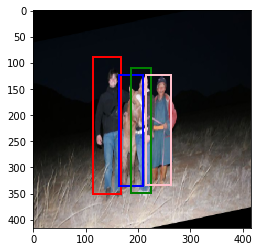

In [655]:
plt.imshow(image[num])

ax = plt.gca()
color = ['red','blue','green','pink','orange']
for i in range(count):
    position = (re[num][0,0,0,i,:] * 416)/13
    print(position)
    rect = patches.Rectangle((position[0]-position[2]/2,position[1]-position[3]/2),
                     position[2],
                     position[3],
                     linewidth=2,
                     edgecolor=color[i%5],
                     fill = False)

    ax.add_patch(rect)


### 모델 정의

In [10]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

In [683]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))


# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, 0])

model = Model([input_image], output)

In [684]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 416, 416, 32) 0           norm_1[0][0]                     
_______________________________________________________________________________________

In [685]:
wt_path = './yolo.weights'

In [686]:
weight_reader = WeightReader(wt_path)

In [687]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [688]:
layer   = model.layers[-2] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

### 손실함수 정의

In [736]:
count = tf.Variable(0)

In [737]:
def custom_loss(y_true, y_pred):
    
    count.assign_add(1)
    mask_shape = tf.shape(y_true)[:4]
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)),'float32')
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])

    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])

    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.math.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    
    ######################################################## error 
    true_boxes = tf.convert_to_tensor(self_true_box(y_true))
    true_xy = true_boxes[..., 0:2]   
    true_wh = true_boxes[..., 2:4]
    
    ########################################################
    a
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)

    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.math.truediv(intersect_areas, union_areas)
    

    best_ious = tf.reduce_max(iou_scores, axis=4)

    conf_mask = tf.math.add(conf_mask,tf.cast(best_ious < 0.6,'float32') * (1 - y_true[..., 4]) * NO_OBJECT_SCALE)

    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE

    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    
    
    
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0,'float32'))
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0,'float32'))
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0,'float32'))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    hello.setting(loss_conf)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    if(count%2):
        tf.print('\nloss_xy:',loss_xy,'loss_wh:',loss_wh,'loss_conf:',loss_conf,'loss_class',loss_class)
        

    
    return loss

### yolov2 모델 학습

In [738]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

In [739]:
tf.config.experimental_run_functions_eagerly(True)

In [743]:
history = model.fit_generator(
    generator = train_batch, 
    steps_per_epoch  = 4, 
    epochs           = 1, 
    verbose          = 1,
)


loss_xy: 0.0771410167 loss_wh: 2.66357255 loss_conf: 0.106551223 loss_class 4.25786734
2/4 [==============>...............] - ETA: 9s - loss: 6.8119
loss_xy: 0.0846738741 loss_wh: 2.15102696 loss_conf: 0.104305558 loss_class 4.26860142
4/4 [==============================] - 28s 7s/step - loss: 7.0072


### 학습은 colab에서 수행된다.

### 모델 불러오기

In [21]:
from tensorflow.keras.models import model_from_json 

In [22]:
json_file = open("./model/yolov2_model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json)

In [23]:
loaded_model.load_weights("./model/yolov2_weight.h5")

### 이미지 예측하기

In [38]:
test_image = cv2.imread('./test_image/image.jpeg')
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)

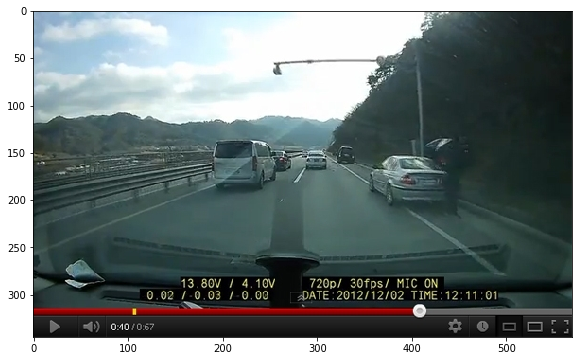

In [39]:
plt.figure(figsize=(13,6))
plt.imshow(test_image)
plt.show()

In [40]:
prec_image = cv2.resize(test_image,(416,416)).astype('float32')
prec_image = prec_image/255.0

In [41]:
image_predict = loaded_model.predict(np.expand_dims(prec_image,axis=0))

In [42]:
image_predict.shape

(1, 13, 13, 5, 85)

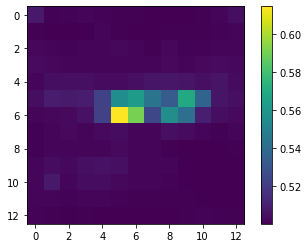

In [54]:
plt.imshow(tf.sigmoid(image_predict[0,:,:,0,4]))
plt.colorbar()

In [49]:
image_predict[0,:,:,0,4]

array([[3.24431062e-02, 2.32191500e-03, 5.23119094e-03, 6.46569161e-03,
        4.72127041e-03, 3.12784454e-03, 2.53855251e-03, 1.13302434e-03,
        1.52092555e-03, 1.80606951e-03, 2.29815673e-03, 8.33444204e-03,
        1.75469443e-02],
       [3.92271020e-03, 5.83974936e-04, 7.71177816e-04, 2.00947281e-03,
        7.28655187e-03, 3.90586210e-03, 1.80442340e-03, 8.44464870e-04,
        2.95194169e-03, 2.59162392e-03, 3.27170244e-03, 5.69184590e-03,
        7.76591711e-03],
       [1.05155669e-02, 6.25170814e-03, 5.39378449e-03, 7.15510221e-03,
        8.29838496e-03, 9.62387212e-03, 6.70219911e-03, 2.40911357e-03,
        1.00075556e-02, 4.20372654e-03, 5.72102796e-03, 6.69446168e-03,
        6.45268336e-03],
       [1.30833518e-02, 9.76794213e-03, 8.20362754e-03, 8.74500442e-03,
        6.83788816e-03, 6.40451629e-03, 7.86749274e-03, 7.65912328e-03,
        1.17215160e-02, 9.06448904e-03, 1.17545826e-02, 1.33401267e-02,
        1.11071495e-02],
       [8.28720070e-03, 1.67046636e-

In [43]:
np.unique(image_predict)

array([-16.851856, -16.707619, -16.70576 , ...,   8.252495,   8.377484,
         8.624194], dtype=float32)

In [44]:
boxes = decode_netout(image_predict[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)

In [45]:
box_image = draw_boxes(test_image,boxes,labels=LABELS)

In [55]:
boxes

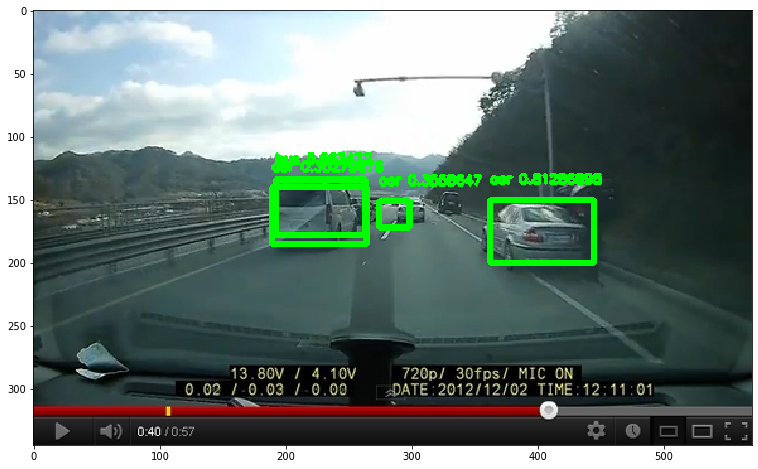

In [46]:
plt.figure(figsize=(15,8))
plt.imshow(box_image.astype('int32'))
plt.show()

### RESULT
- 학습은 항상 수렴하지 않는다. -> NAN으로 빠진다. 
- ADAM 이나 RMSPROP 옵티마이저를 쓰면 학습 도중 중간, 중간 NAN손실로 이어진다.
- SGD을 고려하면, 만약 훈련이 수렴하고 있다면 그때 절대로 NAN손실로 가지 않는다.
- 데이터를 0으로 나눈 값

### Adaptive Method Optimizer가 어떤상황(Object_Detection)에서는 학습에 나쁜 결과를 만든다.
- 논문: **The Marginal Value of Adaptive Gradient Mehtods in Machine Learning**
- 내용: Adaptive method(AdaGrad, RMSPROP, Adam)이 일부 데이터셋에서 나쁜 결과를 보인다. 따라서 모멘텀 최적화, SGD, 네스테로프 경사 가속을 사용하는 것이 나올 수 있다고 주장한다. 
- Gradient descent (GD)나 Stochastic gradient descent (SGD)를 이용하여 찾은 solution이 다른 adaptive methods (e.g. AdaGrad, RMSprop, and Adam)으로 찾은 solution보다 훨씬 generalization 측면에서 뛰어나다.

#### nan

- 1/0 
- 10 -> inf -> nan

In [16]:
np.array([5,np.nan])

array([ 5., nan])

In [26]:
tf.math.is_nan(tf.Variable(np.nan))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [28]:
type(tf.reduce_sum([1,3]))

tensorflow.python.framework.ops.EagerTensor

In [25]:
a = np.array([[1,2],[3,np.nan]])
print(a)
b = np.sum(a)
print(b)
print(np.nan)
tf.math.isnan()
np.isnan(tf.Variable(np.nan))

[[ 1.  2.]
 [ 3. nan]]
nan
nan


AttributeError: module 'tensorflow._api.v2.math' has no attribute 'isnan'

In [201]:
np.array(5/0)

ZeroDivisionError: division by zero

In [ ]:
np.nan